In [1]:
import ROOT, os, sys, glob
import numpy as np
import math
from matplotlib import pyplot as plt
from ROOT import kBlack, kBlue, kRed
from array import array

ROOT.EnableImplicitMT(4); 

Welcome to JupyROOT 6.28/00


In [2]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.1.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M10_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M12_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M25_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M3p5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M40_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M4_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.1.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1

In [3]:
list(glob.glob("/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/*125X_v0.0.root"))

['/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_BsToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-1To10_TuneCP5_14TeV-pythia8_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_DYToLL_M-50_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M15_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M2_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_HAHM_ZdToMuMu_M5_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_JPsiToMuMu_PU200.125X_v0.0.root',
 '/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/l1MuNano_SingleNeutrino_PU200.125X_v0.0.root']

In [4]:
def Normal_h(h1,h2):
    h_p = h1.Clone()
    h_p.Scale(1./h2.Integral())
    return h_p;

In [5]:
def Efficiency_plotter(file_name):
    rdf = ROOT.RDataFrame("Events",f"/eos/cms/store/cmst3/group/l1tr/gpetrucc/dilep-scout/{file_name}")
    def makeDimuonPairs(name, rdf):
        ## define 4-vectors in cartesian coordinates, for easier 
        rdf = rdf.Define(f"{name}Mu_p4", f"ROOT::VecOps::Construct<ROOT::Math::XYZTVector>(ROOT::VecOps::Construct<ROOT::Math::PtEtaPhiMVector>({name}Mu_pt,{name}Mu_eta,{name}Mu_phi,{name}Mu_mass))")
        ## make indices of all the pairs
        rdf = rdf.Define(f"{name}DiMu_indices", f"""
            ROOT::VecOps::RVec<std::pair<int,int>> ret; 
            for (int i = 0, n = n{name}Mu; i < n; ++i) 
                for (int i2 = i+1; i2 < n; ++i2) 
                    ret.emplace_back(i,i2);
            return ret;""")

        #Let us impose a selection criteria here


        ## Make the number of dimuons, for convenience later
        rdf = rdf.Define(f"n{name}DiMu", f"{name}DiMu_indices.size()")
        ## compute the mass, charge
        rdf = rdf.Define(f"{name}DiMu_mass", f"""
            ROOT::RVecF ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(({name}Mu_p4[pair.first]+{name}Mu_p4[pair.second]).M());
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_charge", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back({name}Mu_charge[pair.first]+{name}Mu_charge[pair.second]);
            return ret;""")



        rdf = rdf.Define(f"{name}DiMu_minIdx", f"""
            ROOT::RVecI ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::min(TkMu_GenMuIdx[pair.first],TkMu_GenMuIdx[pair.second]));
            return ret;""")


        rdf = rdf.Define(f"{name}DiMu_eta", f"""
            ROOT::RVecF ret;
            for (const auto & pair : {name}DiMu_indices) 
                ret.emplace_back(std::max(abs({name}Mu_eta[pair.first]),abs({name}Mu_eta[pair.second])));
            return ret;""")
        
        rdf=rdf.Define(f"{name}DiMu_dz",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(({name}Mu_vz[pair.first]-{name}Mu_vz[pair.second]));
            return ret;""")
        #min pT of thw two
        rdf = rdf.Define(f"{name}Mu_minPT",f"""
            ROOT::RVecF ret;
            for(const auto & pair : {name}DiMu_indices)
                ret.emplace_back(std::min({name}Mu_pt[pair.first],{name}Mu_pt[pair.second]));
            return ret;""") #

        return rdf;
    
    entries_no_pair = rdf.Count().GetValue()
    
####################################################################################################################################################################    
    def makeTk_DiMuonPairs(rdf):
    
        #this is to defne DiMuon pairs for different properties
        rdf = rdf.Define(f"TkDiMu_hwIsoSum", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSum[pair.first],TkMu_hwIsoSum[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwIsoSumAp", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(0.03125*(std::max(TkMu_hwIsoSumAp[pair.first],TkMu_hwIsoSumAp[pair.second])));
            return ret;""")

        rdf = rdf.Define(f"TkDiMu_hwQual", f"""
            ROOT::RVecI ret; 
            for (const auto & pair : TkDiMu_indices) 
                ret.emplace_back(std::min(TkMu_hwQual[pair.first],TkMu_hwQual[pair.second]));
            return ret;""")

        return rdf;
    rdf_Tkdimu_one = makeDimuonPairs("Tk",rdf) 
    rdf_Tkdimu = makeTk_DiMuonPairs(rdf_Tkdimu_one)
    h_TkDiMu_mass = rdf_Tkdimu.Histo1D(("","",50,0,50),"TkDiMu_mass")
    
    entries_Tk_pair = rdf_Tkdimu.Count().GetValue()
    
####################################################################################################################################################################
    
    rdf_genDiMu = makeDimuonPairs("Gen",rdf_Tkdimu)
    
    entries_gen_pair = rdf_genDiMu.Count().GetValue()
    
    def select_ind(name, rdf):
    
        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"{name}DiMu_good", f"({name}DiMu_charge<0.1 && {name}DiMu_charge>-0.1) &&({name}DiMu_dz<1 && ({name}DiMu_dz>-1))&&({name}Mu_minPT>2.) && (TkDiMu_hwQual>75) && ({name}DiMu_eta <= 2) && (TkDiMu_hwIsoSumAp<=1.5) && (TkDiMu_hwIsoSum<=1.5)")                    
        rdf = rdf.Define(f"Good{name}DiMu_indices", f"{name}DiMu_indices[{name}DiMu_good]")
        rdf = rdf.Filter(f"Sum({name}DiMu_good)  >= 1")
        rdf = rdf.Define(f"n{name}DiMu_sel",f"Good{name}DiMu_indices.size()")
        rdf = rdf.Define(f"{name}DiMu_selMass",f"{name}DiMu_mass[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selCharge",f"{name}DiMu_charge[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_seldz",f"{name}DiMu_dz[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selMinPt",f"{name}Mu_minPT[{name}DiMu_good]")
        rdf = rdf.Define(f"{name}DiMu_selEta",f"{name}DiMu_eta[{name}DiMu_good]")
        rdf = rdf.Define(f"GoodTkDiMu_hwQual",f"TkDiMu_hwQual[{name}DiMu_good]")
        rdf = rdf.Define(f"GoodTkDiMu_hwIsoSum",f"TkDiMu_hwIsoSum[{name}DiMu_good]")
        rdf = rdf.Define(f"GoodTkDiMu_hwIsoSumAp",f"TkDiMu_hwIsoSumAp[{name}DiMu_good]")
        #rdf = rdf.Define(f"TkDiMu_selEta",f"TkDiMu_eta[{name}DiMu_good]")

        #rdf = rdf.Define(f"GoodTkDiMu_minIdx_{name}",f"TkDiMu_minIdx[{name}DiMu_good]")
        return rdf;

    #rdf_selFeat = select_ind("Gen",rdf_idxSel)
    rdf_Tk_selFeat = select_ind("Tk", rdf_Tkdimu)
    h_TkDiMu_selMass = rdf_Tk_selFeat.Histo1D(("","",50,0,50),"TkDiMu_selMass")
    
####################################################################################################################################################################    
    
    def indexSelect(rdf):
        rdf = rdf.Define("TkDiMu_indMatch","(TkDiMu_minIdx!=-1)" )
        rdf = rdf.Define(f"IdxDiMu_indices", f"TkDiMu_indices[TkDiMu_indMatch]")
        rdf = rdf.Filter(f"Sum(TkDiMu_indMatch)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_Idx",f"IdxDiMu_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxMass",f"TkDiMu_mass[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxCharge",f"TkDiMu_charge[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_Idxdz",f"TkDiMu_dz[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxMinPt",f"TkMu_minPT[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSum",f"TkDiMu_hwIsoSum[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwIsoSumAp",f"TkDiMu_hwIsoSumAp[TkDiMu_indMatch]")
        rdf = rdf.Define(f"TkDiMu_IdxhwQual",f"TkDiMu_hwQual[TkDiMu_indMatch]")
        rdf = rdf.Define("TkDiMu_IdxEta","TkDiMu_eta[TkDiMu_indMatch]")
        return rdf;

    rdf_idxSel = indexSelect(rdf_Tk_selFeat)
    
    entries_idx_pair = rdf_idxSel.Count().GetValue()
    
####################################################################################################################################################################
    
    hIdxTkPairMass = rdf_idxSel.Histo1D(("Tk_Mass_Idx","Idx m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxMass")

   
    
    
    def select_idx_tk(rdf):

        #Let us impose a selection criteria here
        #rdf = rdf.Define(f"{name}DiMu_selind",f"{name}DiMu_indices")
        rdf = rdf.Define(f"TkDiMu_Idx_good", f"(TkDiMu_IdxCharge <0.1 && TkDiMu_IdxCharge > -0.1) &&(TkDiMu_Idxdz <1 && (TkDiMu_Idxdz > -1))&&(TkDiMu_IdxMinPt > 2.) && (TkDiMu_IdxhwQual>75) && (TkDiMu_IdxEta <= 2) && (TkDiMu_IdxhwIsoSum<=1.5) && (TkDiMu_IdxhwIsoSumAp<=1.5)")                    
        rdf = rdf.Define(f"TkDiMu_sel_Idx_indices", f"IdxDiMu_indices[TkDiMu_Idx_good]")
        rdf = rdf.Filter(f"Sum(TkDiMu_Idx_good)  >= 1")
        rdf = rdf.Define(f"nTkDiMu_IdxSel",f"TkDiMu_sel_Idx_indices.size()")
        rdf = rdf.Define(f"TkDiMu_IdxselMass",f"TkDiMu_IdxMass[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselCharge",f"TkDiMu_IdxCharge[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_Idxseldz",f"TkDiMu_Idxdz[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselMinPt",f"TkDiMu_IdxMinPt[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwQual",f"TkDiMu_IdxhwQual[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSum",f"TkDiMu_IdxhwIsoSum[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"TkDiMu_IdxselhwIsoSumAp",f"TkDiMu_IdxhwIsoSumAp[TkDiMu_Idx_good]")
        rdf = rdf.Define(f"GoodTkDiMu_minIdx",f"TkDiMu_minIdx[TkDiMu_Idx_good]")

        return rdf;
    rdf_Tk_IdxselFeat = select_idx_tk(rdf_idxSel)
    
    #rdf_Tk_IdxselFeat = select_idx_tk(rdf_Tk_selFeat)
    
    entries_selIdx_pair = rdf_Tk_IdxselFeat.Count().GetValue()
    
####################################################################################################################################################################    
    hGoodIdxTkPairMass = rdf_Tk_IdxselFeat.Histo1D(("Good Tk_Mass","Good m(#mu#mu)_{Tk};m (GeV);Pairs",50,0,50), "TkDiMu_IdxselMass")
    
    h1 = hGoodIdxTkPairMass.GetPtr()
    h1.SetLineColor(kBlue+1)
    h1.SetLineWidth(2)
    h1.SetMaximum(4000)
    h2 = hIdxTkPairMass.GetPtr()
    h2.SetLineColor(kRed)
    h2.SetLineWidth(2)
    h2.SetMaximum(4000)
    
    def createRatio(h1, h2):
        h3 = h1.Clone("h3")
        h3.SetLineColor(kBlack)
        h3.SetMarkerStyle(21)
        h3.SetTitle("")
        h3.SetMinimum(0)
        h3.SetMaximum(1.2)
        # Set up plot for markers and errors
        h3.Sumw2() #what is this used for (removal of zeros is the rough idea I have)
        h3.SetStats(0)
        h3.Divide(h2)

    #     # Adjust y-axis settings
        y = h3.GetYaxis()
        y.SetTitle("ratio h1/h2 ")
        y.SetNdivisions(505)
        y.SetTitleSize(20)
        y.SetTitleFont(43)
        y.SetTitleOffset(1.55)
        y.SetLabelFont(43)
        y.SetLabelSize(15)

    #     # Adjust x-axis settings
        x = h3.GetXaxis()
        x.SetTitleSize(20)
        x.SetTitleFont(43)
        x.SetTitleOffset(4.0)
        x.SetLabelFont(43)
        x.SetLabelSize(15)

        return h3;
    
    
    h3 = createRatio(h1, h2)
    
    e1 = entries_selIdx_pair/entries_no_pair
    e2 = entries_selIdx_pair/entries_idx_pair
    
    
    return dict(h1=h1, h2=h2, h3=h3, e1=e1, e2=e2, entries_idx_pair=entries_idx_pair,entries_Tk_pair=entries_Tk_pair, h_TkDiMu_mass=h_TkDiMu_mass, h_TkDiMu_selMass=h_TkDiMu_selMass);

In [6]:
def dY_Number(h, Freq, T, entries):
    h_final = h.Clone()
    h_final.Scale((Freq*T)/entries)
    return h_final;


In [17]:
def signal_strength(Mass, cross_sec, L):
    #data_bg = {}
    m = float(Mass.replace("p","."))

    
    #This is for the single neutrino background
    data_bg_1 = Efficiency_plotter("l1MuNano_SingleNeutrino_big_PU200.125X_v0.1.root")
    
    h5_bg_1 = dY_Number(data_bg_1['h_TkDiMu_selMass'].GetPtr(), 35*(10**6), 53.5*(10**5), data_bg_1['entries_Tk_pair']) #for single neutrino
    
    k=h5_bg_1.GetXaxis().FindBin(m)
    N_b_by_m_1=(h5_bg_1.GetBinContent(k)/(h5_bg_1.GetXaxis().GetBinWidth(k)))
    
###############################################################################################################################################################    
    
     #This is for the Drell yan background
    data_bg_2 = Efficiency_plotter("l1MuNano_DYToLL_M-10To50_PU200.125X_v0.0.root")
    
    h5_bg_2 = dY_Number(data_bg_2['h1'], 21.3*(10**6), 400, data_bg_2['entries_Tk_pair']) #for single neutrino
    
    h=h5_bg_2.GetXaxis().FindBin(m)
    N_b_by_m_2=(h5_bg_2.GetBinContent(h)/(h5_bg_2.GetXaxis().GetBinWidth(h)))
    
###############################################################################################################################################################   
    
    N_b_by_m = N_b_by_m_1 + N_b_by_m_2
    
###############################################################################################################################################################    
    #This is for the signal
    file_name = f"l1MuNano_HAHM_ZdToMuMu_M{Mass}_PU200.125X_v0.1.root"
    data_sig = Efficiency_plotter(file_name)
    
    h4_sig = data_sig['h1'].Clone()
    h4_sig.Scale((((cross_sec*(10**3))*(3e-6/(0.02**2)))*L)/data_sig['entries_idx_pair'])
    
    #fitting
    h5 = h4_sig.Clone()
    fit = ROOT.TF1("fit", "[0]*exp(-0.5*((x-[1])/[2])^2)", 0.8*m, 1.2*m)
    fit.SetParameter(1, m)
    fit.SetParameter(2, 0.69071)
   
    h5.Fit("fit", "0", "",0.8*m, 1.2*m)
    std = fit.GetParameter(2)
    
    #Calculating N_s
    N_s = h4_sig.Integral(0,h4_sig.GetNbinsX()+1)
    
###############################################################################################################################################################    
    
    #Calculating strength
    strength = N_s/((N_b_by_m*(2*std))**0.5)
    
    
    return dict(strength = strength, std = std, h5_bg_1 = h5_bg_1, h5_bg_2 = h5_bg_2);

    


In [18]:
s = signal_strength("25",21.53,400)
print(s)

{'strength': 1.07310510798004, 'std': 0.45901129128307705, 'h5_bg_1': <cppyy.gbl.TH1D object at 0x279d6f90>, 'h5_bg_2': <cppyy.gbl.TH1D object at 0x27643cb0>}
 FCN=282.518 FROM MIGRAD    STATUS=CONVERGED     220 CALLS         221 TOTAL
                     EDM=3.57754e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.21588e+04   1.47811e+03   6.22921e+00  -1.70664e-07
   2  p1           2.49870e+01   7.08702e-03   4.91163e-05  -3.36857e-03
   3  p2           4.59011e-01   8.76092e-03   3.54281e-05  -5.26620e-02


In [19]:
t = signal_strength("3p5",(2e-2/8e-3)*((0.02**2)/3e-6),400) #25,15,10,3p5,12,2,4,5,7
print(t)

{'strength': (2.2474302586581467e-19-0.003670332148375998j), 'std': -30983.176059659334, 'h5_bg_1': <cppyy.gbl.TH1D object at 0x2825bf80>, 'h5_bg_2': <cppyy.gbl.TH1D object at 0x2951f6a0>}
 FCN=3.79558e-12 FROM HESSE     STATUS=FAILED         15 CALLS         135 TOTAL
                     EDM=1.51823e-11    STRATEGY= 1  ERROR MATRIX UNCERTAINTY 100.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.08397e+05   8.32726e+04   3.09051e+00   4.67915e-11
   2  p1           3.50000e+00   2.84041e-01   3.09839e+00   0.00000e+00
   3  p2          -3.09832e+04   2.93043e-01  -0.00000e+00   0.00000e+00


 FCN=21.5566 FROM MIGRAD    STATUS=CONVERGED     359 CALLS         360 TOTAL
                     EDM=1.11895e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.30126e+05   2.39094e+04   1.11186e+01   1.06129e-08
   2  p1           9.97011e+00   7.74265e-03   1.53129e-05   1.67567e-02
   3  p2           4.09063e-01   1.39208e-02   1.13390e-05   1.93184e-02


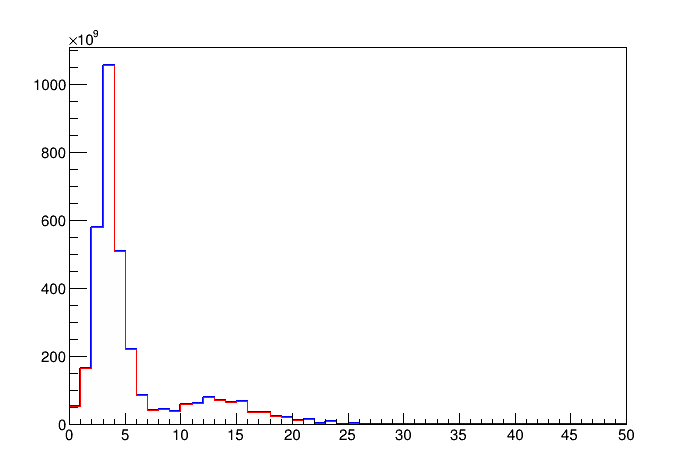

In [20]:
# gr= ROOT.TGraph()
# gr_std = ROOT.TGraph()
L=400
cross_sec = [146.7, 92.96, 64.20, 21.53,7.459, (2e-2/5e-3)*((0.02**2)/3e-6), (2e-2/8e-3)*((0.02**2)/3e-6), (3e-2/2.5e-2)*((0.02**2)/3e-6) , (3e-2/3e-2)*((0.02**2)/3e-6), (3e-2/5e-2)*((0.02**2)/3e-6)]
# for j,i in enumerate(["10","12","15","25","40","2","3p5","4","5","7"]):
# #     [h1,h2,h3],e1,e2=Efficiency_plotter(f"l1MuNano_HAHM_ZdToMuMu_M{i}_PU200.125X_v0.1.root")
# #     print(f"for dark photon mass {i} #################################")
# #     print(f"Efficiency of the selection for {i} with respect to total unpaired muons is {e1}")
# #     print(f"Efficiency of the selection for {i} with respect to paired index matched muons is {e2}")
# #     print("")
   
#     sens = signal_strength(i, cross_sec[j], L)
#     strength = sens['strength']
#     std = sens['std']
#     mass = float(i.replace("p","."))
#     n = gr.GetN()
#     gr.Set(n+1) # add one point
#     gr.SetPoint(n, mass, strength)
#     gr_std.SetPoint(n,mass,std)
    
# c1 = ROOT.TCanvas() 
# gr.Sort()
# y = gr.GetYaxis()
# y.SetTitle("Sensitivity of the signal")
# x = gr.GetXaxis()
# x.SetTitle("Mass of Dark Photon")
# gr.SetTitle("Sensitivity of signal with respect to mass of dark photon")
# gr.SetLineColor(ROOT.kMagenta)
# c1 = ROOT.TCanvas() 
# gr.Sort()
# y = gr.GetYaxis()
# y.SetTitle("Sensitivity of the signal")
# x = gr.GetXaxis()
# x.SetTitle("Mass of Dark Photon")
# gr.SetTitle("Sensitivity of signal with respect to mass of dark photon")
# gr.SetLineColor(ROOT.kOrange+8)
# gr.SetMarkerStyle(20) 
# gr.Draw("APL")
# c1.Draw()    
# c1.SaveAs("sensitivity_vs_mass.png")

# gr.Draw("APC")
# c1.Draw()    
# c1.SaveAs("sensitivity_vs_mass.png")


# c2 = ROOT.TCanvas() 
# gr_std.Sort()
# y = gr_std.GetYaxis()
# y.SetTitle("standard deviation of the signal")
# x = gr_std.GetXaxis()
# x.SetTitle("Mass of Dark Photon")
# gr_std.SetTitle("STD of signal with respect to mass of dark photon")
# gr_std.SetLineColor(ROOT.kMagenta)
# gr_std.SetMarkerStyle(20) 
# gr_std.Draw("APL")
# c2.SaveAs("std_vs_mass.png")
# c2.Draw()  

data = signal_strength("10", 146.7, L)

c3 = ROOT.TCanvas()
hs = ROOT.THStack()
h_bg1 = data['h5_bg_1']
h_bg1.SetLineColor(kRed)
hs.Add(h_bg1)
h_bg2 = data['h5_bg_2']
h_bg2.SetLineColor(kBlue)
hs.Add(h_bg2)
hs.Draw("hist")
c3.Draw()

In [21]:
#acceptance 5e-3 for 2
           #2.5e-2 for 4
           #3e-2 for 5
           #5e-2 for 7
#cross sec * accept
#     
f=3e-2/5e-2
print(f)

0.6


Info in <TCanvas::Print>: png file cross_sec_vs_mass.png has been created


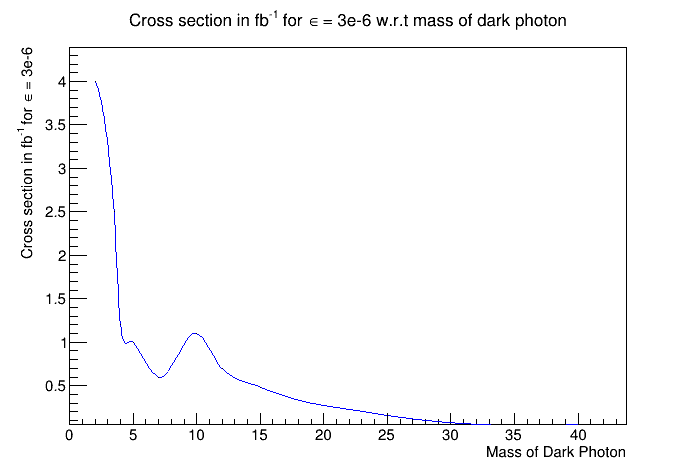

In [14]:
gr_cross = ROOT.TGraph()

for k,l in enumerate(["10","12","15","25","40","2","3p5","4","5","7"]):
    N = gr_cross.GetN()
    gr_cross.Set(N+1) # add one point
    M = float(l.replace("p","."))
    gr_cross.SetPoint(N, M, cross_sec[k]*(3e-6/(0.02**2)))
    
c3 = ROOT.TCanvas() 
gr_cross.Sort()
y = gr_cross.GetYaxis()
y.SetTitle("Cross section in fb^{-1} for #epsilon = 3e-6")
x = gr_cross.GetXaxis()
x.SetTitle("Mass of Dark Photon")
gr_cross.SetTitle("Cross section in fb^{-1} for #epsilon = 3e-6 w.r.t mass of dark photon")
gr_cross.SetLineColor(ROOT.kBlue)

gr_cross.Draw("APC")
c3.Draw()    
c3.SaveAs("cross_sec_vs_mass.png")
   